# **Assignment 3:** Clustering

### **Worked hours:** Sidner 18h, Lukas 18h
### **Authors:** Sidner Magnéli, Lukas Martinsson 


These questions concern the main conformation of proteins. Part of a protein's main chain is
shown in Figure 1. A protein chain is able to fold into its native conformation by rotation
around two of the bonds in the main chain, designated f (phi) and y (psi). Some combinations
of phi and psi are impossible (e.g. some atoms clash into each other if we try to force the main
chain to have a particular combination of phi and psi). Some other combinations of phi and
psi are very common since they are energetically favourable. To understand the problem
domain better, please look at:

• http://bioinformatics.org/molvis/phipsi/

• http://tinyurl.com/RamachandranPrincipleYouTube

The provided data file contains a list of phi and psi combinations that have been observed in
proteins. The angles are measured here in degrees.
___

In [113]:
# global imports and configuration
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# set plot style
sns.set_style("darkgrid")
# plt.style.use('seaborn')

CMAP = 'viridis'

### **Load dataset**

In [114]:
df_raw = pd.read_csv('./datasets/data_all.csv')
df_raw.head(5)

,residue name,position,chain,phi,psi
0,LYS,10,A,-149.312855,142.657714
1,PRO,11,A,-44.283210,136.002076
2,LYS,12,A,-119.972621,-168.705263
3,LEU,13,A,-135.317212,137.143523
4,LEU,14,A,-104.851467,95.928520


Remove any rows with only NaN values

In [115]:
df = df_raw.dropna(how='all')

## **Part 1:** Show the distribution of phi and psi combinations using:

### **1.a)** A scatter plot

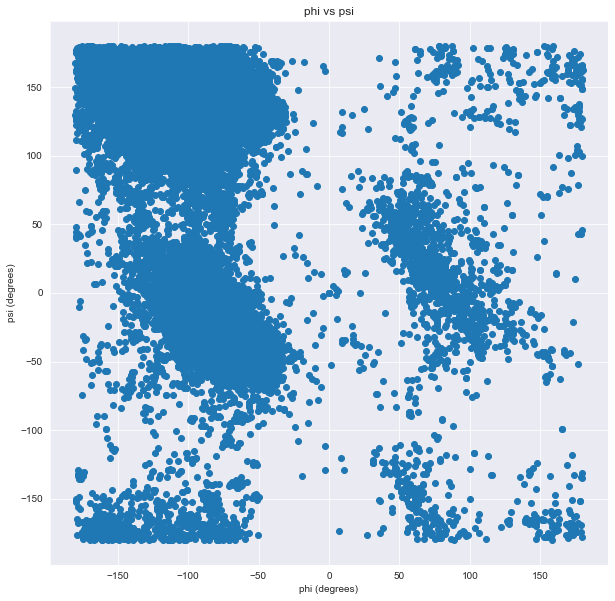

In [116]:
plt.figure(figsize=(10,10))
plt.scatter(x=df['phi'],y=df['psi'])
plt.title('phi vs psi')
plt.xlabel('phi (degrees)')
plt.ylabel('psi (degrees)')
plt.show()

### **1.b)** A heat map

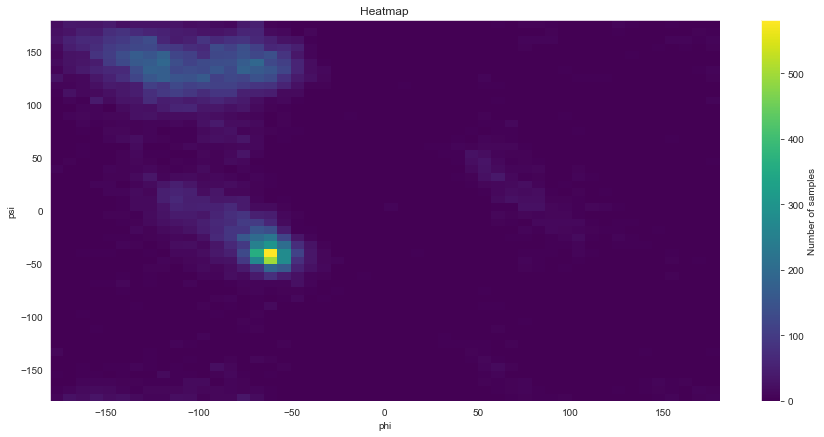

In [117]:
# create heat map
plt.figure(figsize=(15, 7))
plt.hist2d(df['phi'],df['psi'], bins=50, cmap=CMAP)

# Plot a colorbar with label.
cb = plt.colorbar()
cb.set_label('Number of samples')

# plot configs
plt.xlabel('phi'); plt.ylabel('psi')
plt.title('Heatmap')
plt.show()

## **Part 2**: Use the K-means clustering method to cluster the phi and psi angle combinations in the data file

In [118]:
from sklearn.cluster import KMeans

# pick input features
X = df.loc[:,['phi', 'psi']]

### **2.a)** Experiment with different values of K. Suggest an appropriate value of K for this task and motivate this choice.

We show the clustering by generating scatterplots for increasing values of **k**.

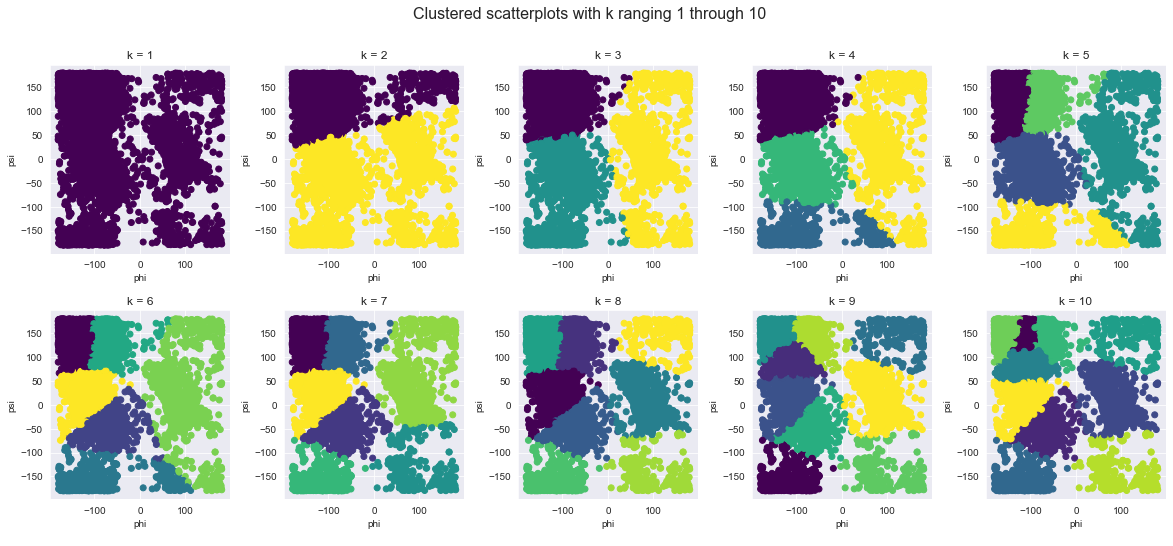

In [119]:
ks = range(1,11)
mean_squared_error = []

i,j=0,0
fig, axs = plt.subplots(2,5, figsize=(20, 8))
for k in ks:
  # create and train model
  kmean_model = KMeans(n_clusters=k, random_state=0).fit(X)
  
  # predict clusters 
  y_pred = kmean_model.predict(X)

  # store mean squared error / k for elbow plot
  mean_squared_error.append(kmean_model.inertia_)

  axs[i][j].scatter(x=X['phi'],y=X['psi'],c=y_pred,cmap=CMAP)
  axs[i][j].set_xlabel('phi\n')
  axs[i][j].set_ylabel('psi')
  axs[i][j].set_title(f'k = {k}')

  j+=1
  if j%5==0:
      i+=1
      j=0

plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Clustered scatterplots with k ranging 1 through 10', fontsize=16)
plt.show()

By looking at the scatterplot for different k values we can see several things. Firstly, when k=2 we can see that the data points are more densely gathered in the right upper left corner. This would not have been our original guess if we were to manually create 2 clusters.
And although the cluster may vary each time the method is run because of the randomized starting points it still gives a clear indicator of when the k value reaches an appropriate value.
By looking at the difference between K=3 and K=4 visually the clusters are better for  k=3. However, k=5 also has reasonable clusters. So, it is hard to say visually, therefore we also want to make use of the elbow method. By combining what we can see visually and through the elbow method, we can give a better suggestion for an appropriate K.


Generate an elbow plot to help determine the optimal **k** value (number of of clusters).

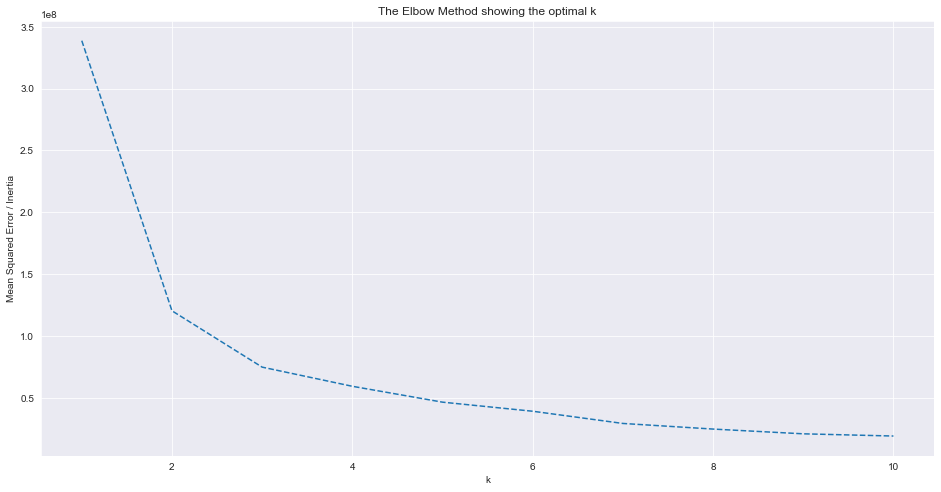

In [120]:
plt.figure(figsize=(16,8))
plt.plot(ks, mean_squared_error, '--')
plt.xlabel('k')
plt.ylabel('Mean Squared Error / Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Looking at the elbow plot we can see that the largest change in rate of decline is at `k = 2` and `k = 3`. Afterwards the change is more or less constant from 3 to 7. Therefore, by combining what we saw, combined with the fact that the cluster may vary depending on the starting points and that the clusters in the right corners are sparse (which will indicate that when we remove a percentage of data to validate those cluster they will not be as pronounced) we would choose k=3 or k=4. More discussion concerning this will follow in 2b since there we will be discussing the correlation between a modified set compared to the original

### **2.b)** *Validate the clusters that are found with the chosen value of K. Hint: See the slides for Lecture 6, Section Validating clustering.*)*   

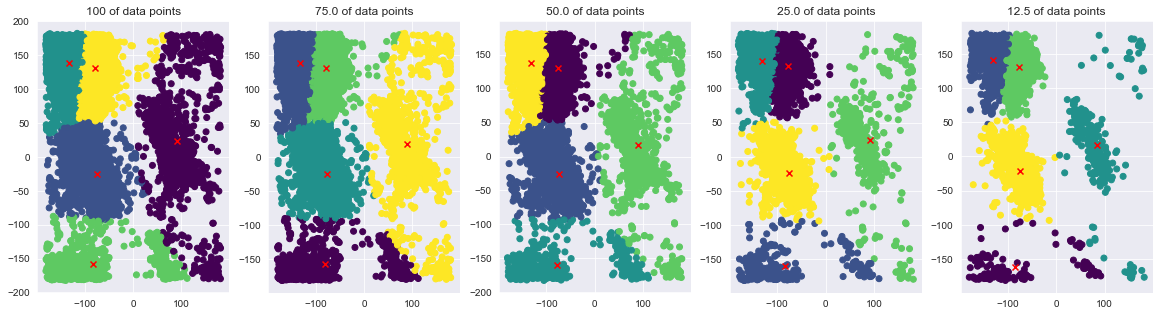

In [121]:
k_optimal = 5
sample_limits = [1,0.75,0.5,0.25,0.125]
fig, axs = plt.subplots(1, len(sample_limits), figsize=(20,5))

for i in range(0,len(sample_limits)):
    # varying the number of samples enables ut to demonstrate the difference in the selected centriods
    n_samples = int(len(X)*sample_limits[i])

    # makes n_samples blobs
    X_blob, _ = make_blobs(n_samples=n_samples, centers=X)

    # Fitting the data and specifying the clusters to 5 and predicting the kmean in each dataset
    model_kmeans = KMeans(n_clusters=k_optimal, random_state=0).fit(X_blob)
    y_pred = model_kmeans.predict(X_blob)
    
    axs[i].scatter(X_blob[:,0], X_blob[:,1], c=y_pred, cmap=CMAP)

    # Plots the data  
    axs[i].scatter(model_kmeans.cluster_centers_[:, 0], model_kmeans.cluster_centers_[:, 1], marker='x',c='red')
    axs[i].set_title(f'{sample_limits[i]*100} of data points')

plt.show()

One way of removing an appropriate number of samples is by using a percentage of the whole dataset. By removing more samples for each plot, one can study the effect of it by looking at the centroids and seeing how they move when more samples are removed. If the centroids stay in place, it's an indication of a stable clustering for the dataset under investigation. In the grid of scatterplots above the rows show clustering for a reduced set of samples from left to right. The first row shows the effect for k = 3 and the second for K = 9. By looking closely, one sees that the centroids on the first row stay in place to a much higher degree than those of the second row, indicating that the prior is a more stable clustering.

Another way of validating clustering is by looking at the mean silhouette score over the entire dataset for each value of k. This coefficient, ranging from 1 to -1 gives an indication of how tightly grouped all the points in the cluster are. Thus, the mean silhouette coefficient over all data of the entire dataset is a measure of how appropriately the data have been clustered. If there are too many or too few clusters, as may occur when a poor choice of k is used in the clustering algorithm (such as k-means), some of the clusters will typically display much narrower silhouettes than the rest. Thus, silhouette plots and means may be used to determine the natural number of clusters within a dataset


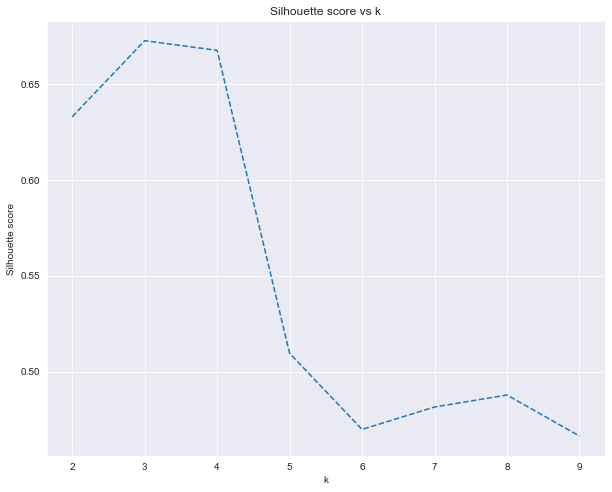

In [122]:
from sklearn.metrics import silhouette_score
silhouette_score_list = []
ks = range(2,10)
for k in ks:
    model_kmeans = KMeans(n_clusters=k, random_state=0).fit(X)

    # get silhouette score for different k values
    score = silhouette_score(X,model_kmeans.labels_,random_state=0)
    silhouette_score_list.append(score)

plt.figure(figsize=(10,8))
plt.plot(ks, silhouette_score_list, '--')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs k')
plt.show()

The above graph shows that the highest silhouette scores are achieved for k = 3 and k = 4. This validates that, indeed, 3 or 4 clusters seem to be the correct classification for this dataset. In order to decide further, whether to pick k = 3 or k = 4, one would have to investigate and understand the data more deeply.

### **2.c)** *Do the clusters found in part **(a)** seem reasonable?*

By inspecting the both the mean squared error and silhouette score graphs, one sees that k = 3 shows the best results overall, tightly followed by k = 4. This suggests three clusters as the best fit for this dataset. However, it's important to consider the scatterplots, which visualize the actual clusters, in 2a) when making statements about the performance.

By simply looking at the scatterplots, one notices there are no obvious clearly separated clusters. There are some tendencies of groupings which the clustering algorithm seems to recognize as k increases. Interestingly, higher values of k score lower as mentioned above. This goes to show that visual inspection of the data with the intention of clustering, although powerful, should still be complemented by considering statistical metrics such as the ones used above, in order to pick a fitting number of clusters for the dataset.


### **2.d)** Can you change the data to get better results (or the same results in a simpler way)? (Hint: since both phi and psi are periodic attributes, you can think of shifting/translating them by some value and then use the modulo operation.)

Due to properties of the angle’s phi and psi, one can modify the range of each axis on the scatterplots to better isolate the clusters from start. Here, we use the fact that angles are periodic, meaning that every angle has an equivalent angle 360° from it in each direction (positive and negative). Hence, looking at the plot from 1a), each axis wraps around.

So, how can we use this realization. Looking closer at the scatterplot one sees that there's a relatively clear separation between the clusters at 0° if one were to draw a vertical line from the phi axis. Similarly, this is also the case if one were to draw a horizontal line at -100° on the psi axis. If we shift these points so they both become the starting point of each axis, the cluster should be much more obvious.

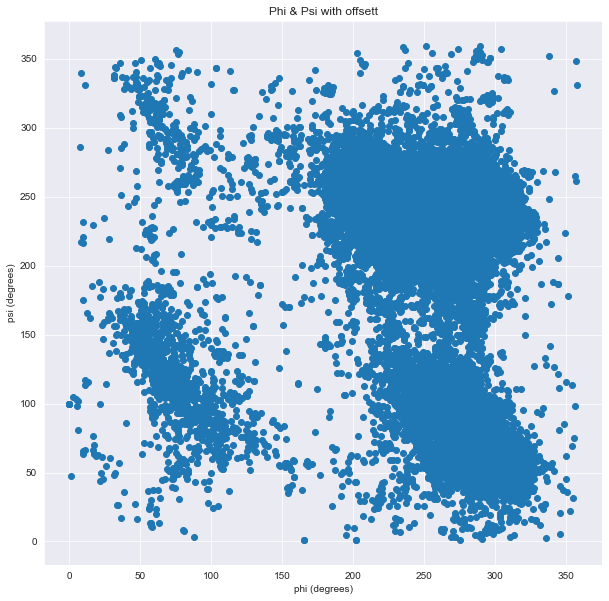

In [123]:
phi_angle_offset = 360
psi_angle_offset = 100

df['phi shifted 360°'] = df.apply(lambda row: ((row.phi + phi_angle_offset) % 360), axis=1)
df['psi shifted 100°'] = df.apply(lambda row: ((row.psi + psi_angle_offset) % 360), axis=1)

plt.figure(figsize=(10,10))
plt.scatter(x=df['phi shifted 360°'], y=df['psi shifted 100°'])
plt.xlabel('phi (degrees)')
plt.ylabel('psi (degrees)')
plt.title('Phi & Psi with offsett')
plt.show()

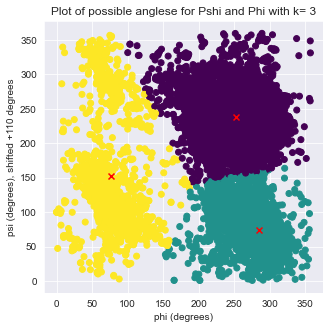

In [124]:
# using all data points

X = df.loc[:,['phi shifted 360°', 'psi shifted 100°']]

plt.figure(figsize=(5,5))

# Specify the number of clusters (4) and fit the data X
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
y_kmeans = kmeans.predict(X)

# Plotting the cluster centers and the data points on a 2D plane
plt.scatter(X['phi shifted 360°'], X['psi shifted 100°'],c=y_kmeans, cmap='viridis')

# Plotting clusters centers   
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x',c='red')
    
plt.title('Plot of possible anglese for Pshi and Phi with k= 3')
plt.xlabel('phi (degrees)')
plt.ylabel('psi (degrees), shifted +110 degrees')
plt.show()

## **Part 3**: Use the DBSCAN method to cluster the phi and psi angle combinations in the data file.

In [125]:
# import relevant libraries
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

X = df[['phi shifted 360°', 'psi shifted 100°']]

Since 3.a and 3.b want to have a motivation of why we chose different variables such as eps we have to be able to analyze different values for these to motivate our decision.

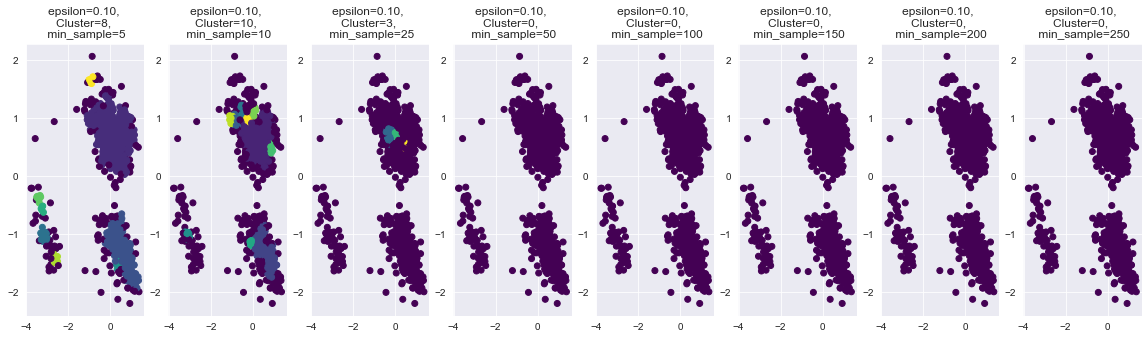

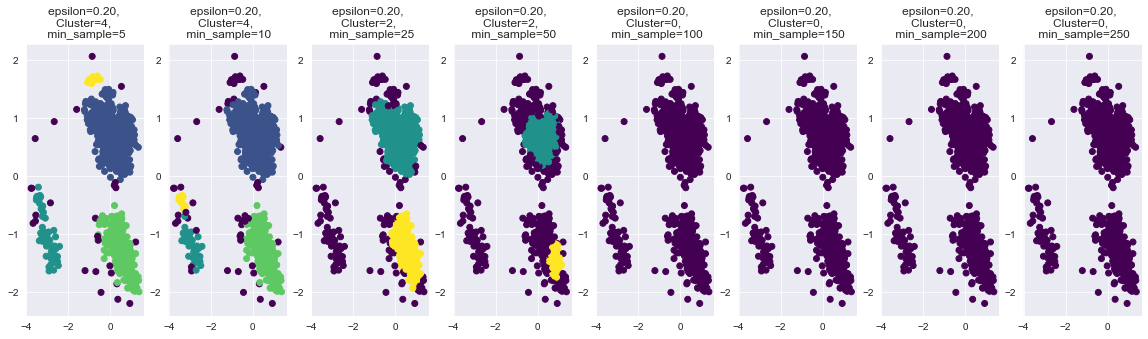

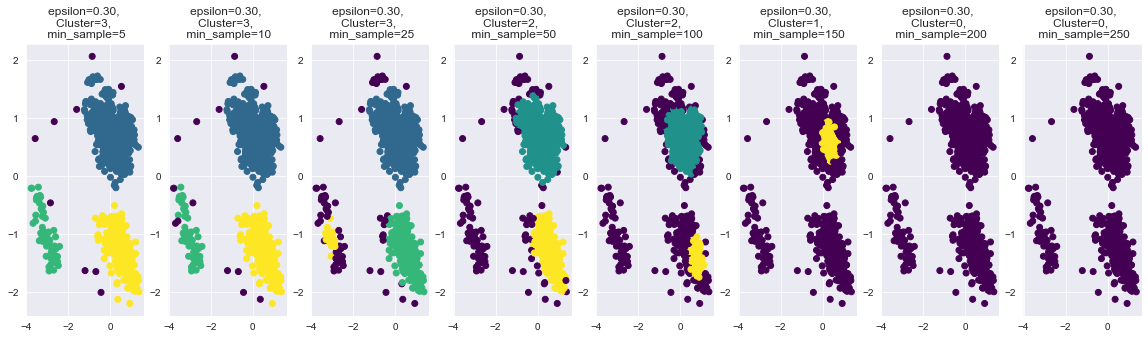

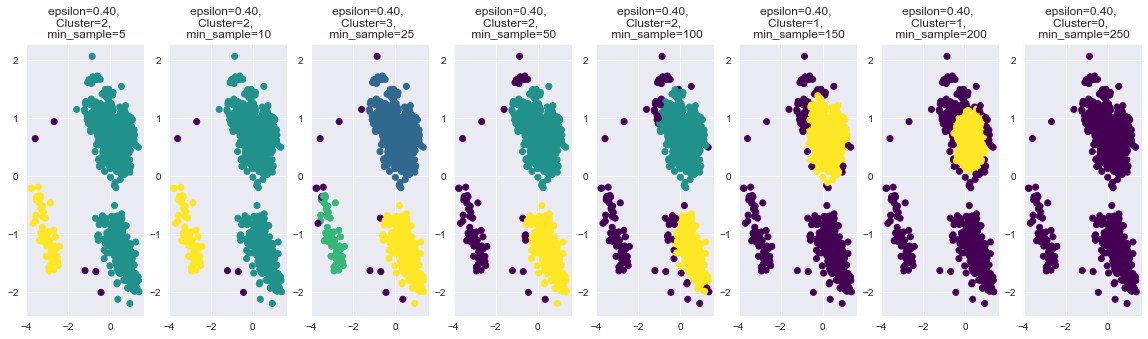

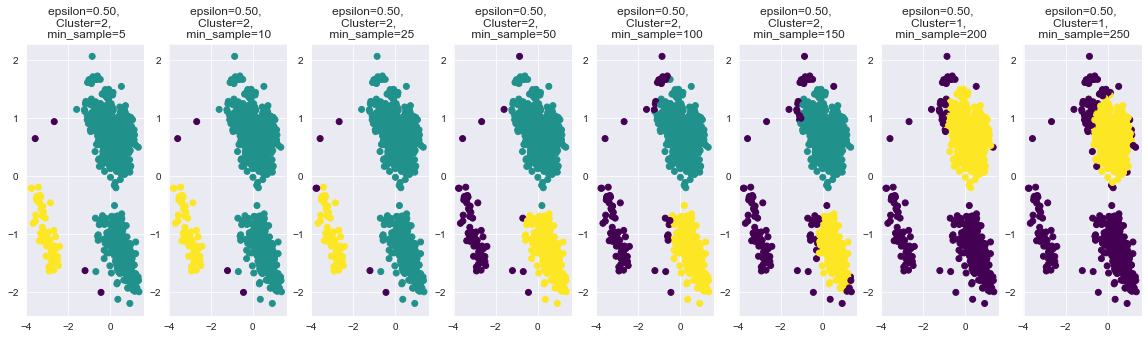

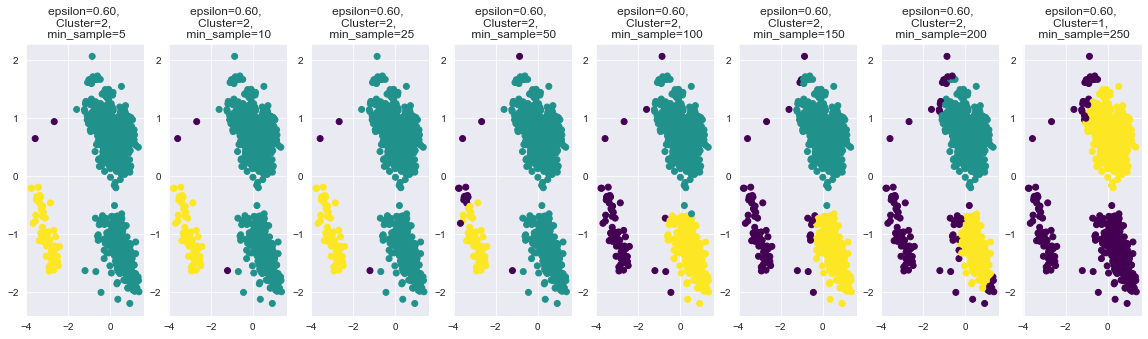

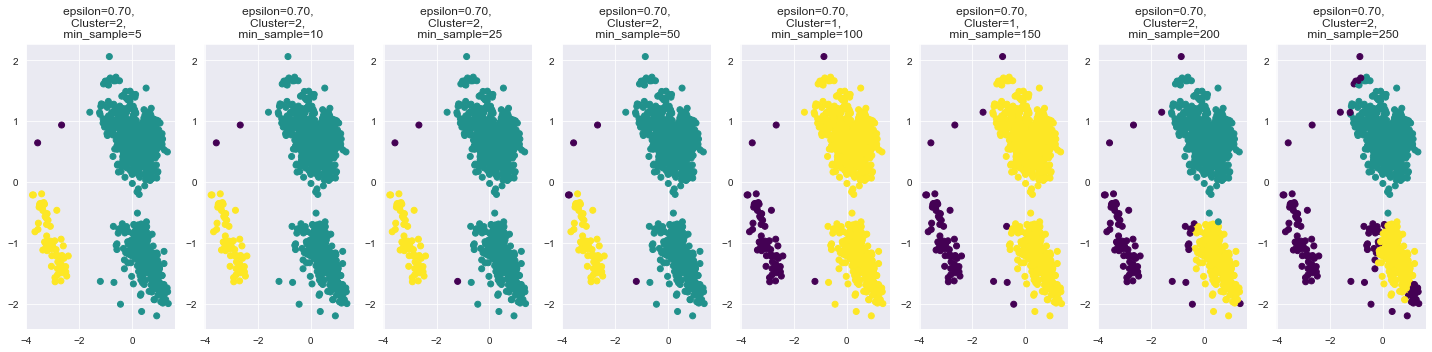

In [126]:

# Choosing sample and eps values
min_samples = [5,10,25,50,100,150,200,250]
eps = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
length_samples = len(min_samples)
length_eps = len(eps)
n_samples = 1000

if n_samples!=len(df):
  X, y = make_blobs(n_samples=n_samples, centers=df[['phi shifted 360°', 'psi shifted 100°']])        
else:
  X = df[['phi shifted 360°', 'psi shifted 100°']]
X = StandardScaler().fit_transform(X)

#Creates scatterplots with different eps and min_samples values
for i in range(0, length_eps):
    fig, ax = plt.subplots(1, length_samples, figsize=(20,5))
    for j in range (0, length_samples):
        
        # Compute DBSCAN with the different values
        db = DBSCAN(eps=eps[i], min_samples=min_samples[j]).fit(X)
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        y_pred = db.fit_predict(X)

        ax[j].scatter(X[:,0], X[:,1],c=y_pred, cmap=CMAP)
        ax[j].set_title('epsilon=%.2f, \nCluster=%d, \n min_sample=%d' %(eps[i], n_clusters_, min_samples[j]))

X, _ = make_blobs(n_samples=n_samples, centers=X)

plt.tight_layout()
plt.show()

### **3.a)** Motivate:

* **i)** *the choice of the minimum number of samples in the neighborhood for a point to be considered as a core point*


Picking a suitable minimum number of samples in the neighborhood for a point to be considered as a core point is something which should preferably be done by a domain expert with deep knowledge of the data. As this does not really apply to us, we found a suitable threshold through trial and error. One thing to look out for is setting the threshold to low as this allows for more outliers to be clustered, which is something we want to avoid.

One frequent answer to this question was to use the natural logarithm of the number of samples as a starting point. However, for our application, with over 29000 samples, this yielded a threshold of 10 samples which proved to be too low. After trial and error, we've come to the conclusion that the minimum should lie somewhere between 150 and 200 while epsilon is around 0.7 for the best results.

* **ii)** the choice of the maximum distance between two samples belonging to the same neighbourhood (“eps” or “epsilon”).

In layman’s terms, we find a suitable value for epsilon by calculating the distance to the nearest n points for each point, sorting and plotting the results. Then we look to see where the change is most pronounced and select that as epsilon.

Text(0.5, 0, 'distance to nearest n points')

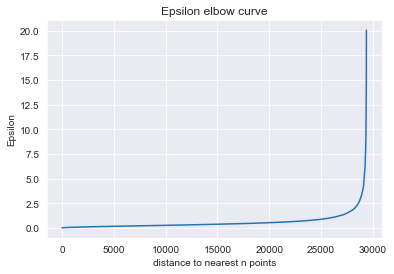

In [127]:
X = df[['phi shifted 360°', 'psi shifted 100°']]
nearest_neighbours = NearestNeighbors(n_neighbors=2).fit(X)
distances, _ = nearest_neighbours.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title('Epsilon elbow curve')
plt.ylabel('Epsilon')
plt.xlabel('distance to nearest n points')

Looking at this curve the best fitting epsilon should lie somewhere between 25000 and 30000 on the bottom axis.

In [128]:
for i in range(25000,30000,1000):
  print(f'distance to nearest n points: {i}\nepsilon: {distances[i]}')

distance to nearest n points: 25000
epsilon: 0.8785587235023198
distance to nearest n points: 26000
epsilon: 1.0403608175022654
distance to nearest n points: 27000
epsilon: 1.2929875478441204
distance to nearest n points: 28000
epsilon: 1.8011889938518397
distance to nearest n points: 29000
epsilon: 3.7488999275547665


The values shown above gives no obvious improvement compared to the combination of values, epsilon = 0.5 and minimum sample threshold = 200, which we got through trial and error.

### **3.b)** Highlight the clusters found using DBSCAN and any outliers in a scatter plot. How many outliers are found? Plot a bar chart to show which amino acid residue types are most frequently outliers.

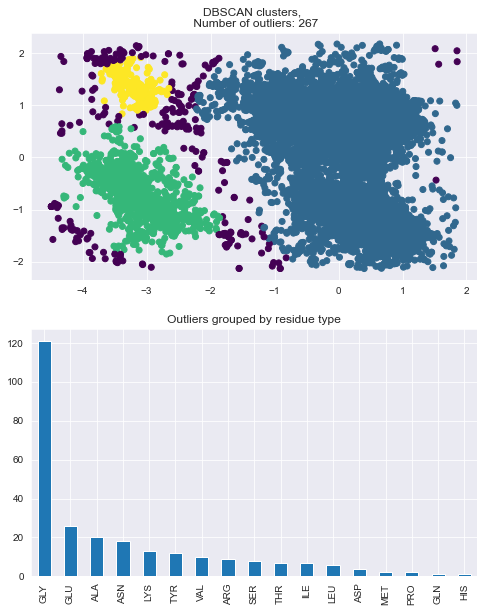

In [129]:
X = df[['phi shifted 360°', 'psi shifted 100°']]
X = StandardScaler().fit_transform(X)
eps = 0.5
min_sample_threshold = 200

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))

# generate DBSAN clustering
model_dbscan = DBSCAN(eps=eps, min_samples=min_sample_threshold).fit(X)
labels = model_dbscan.labels_
number_of_outliers = list(labels).count(-1) # outliers are given the label -1.
y_pred = model_dbscan.fit_predict(X)

# create 
ax1.scatter(X[:,0], X[:,1],c=y_pred, cmap=CMAP)
ax1.set_title(f'DBSCAN clusters, \n Number of outliers: {number_of_outliers}')

# Creating a new column with labels of being in a neighborhood or noise
df['labels'] = list(labels)

#filter out and only keep the noise 
df_outliers = df[(df['labels'] == -1)]
bar = df_outliers['residue name'].value_counts(sort=True).plot.bar()
plt.title('Outliers grouped by residue type')
plt.show()

### **3.c)** Compare the clusters found by DBSCAN with those found using K-means.

![kmeans](kmeans.png)
![dbscan](dbscan.png)

As we can see, K-means and DBSCAN clusters are a bit different. There are several reasons for this. One is that K-means does not have any noise, aka outliers. This is because it is not a density based method but instead assigns every single sample to it's nearest cluster. This simplicity comes with its drawbacks. Firstly, it does not take outliers into account. This could skew the placements of the clusters if there are a lot of outliers. Furthermore, since the clusters initial placements are random the result can vary and sometime not be as good. DBSCAN on the other hand is a lot more precise and does not vary in the same way. However, when using DBSCAN, two variables, epsilon, and min_sample have to be chosen with care. There are some standard values, for example 0.5 for epsilon. However, we chose on some of our tasks to use a different value for better results instead. Therefore, it is crucial to understand what the different values will do for the particular domain.

### **3.d)** Discuss whether the clusters found using DBSCAN are robust to small changes in the minimum number of samples in the neighbourhood for a point to be considered as a core point, and/or the choice of the maximum distance between two samples belonging to the same neighbourhood (“eps” or “epsilon”).

As shown in 3.a a small difference in min_sample does not change the results a lot, meaning it is robust. Epsilon however is the opposite, a small change will drastically change t he results.

## **Part 4**: The data file can be stratified by amino acid residue type. 
Remember that when doing clustering using DBSCAN for a) and b) here, the parameters might have to be adjusted from those used in previous questions.

### **4.a)** Use DBSCAN to cluster the data that have residue type PRO. Investigate how the clusters found for amino acid residues of type PRO differ from the general clusters (i.e., the clusters that you get from DBSCAN with mixed residue types in question 3).

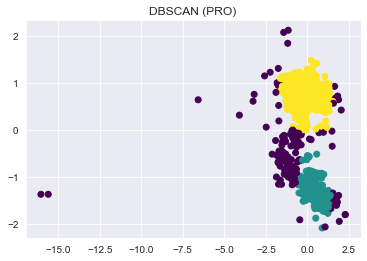

In [131]:
# generate DBSAN clustering
model_dbscan = DBSCAN(eps=0.5, min_samples=200).fit(X)
labels = model_dbscan.labels_
number_of_outliers = list(labels).count(-1) # outliers are given the label -1.
y_pred = model_dbscan.fit_predict(X)

df_PRO = df[(df['residue name'] == 'PRO')]
X = df_PRO[['phi shifted 360°', 'psi shifted 100°']]
X = StandardScaler().fit_transform(X)

# create 
plt.scatter(X[:,0], X[:,1],c=y_pred, cmap=CMAP)
plt.title("DBSCAN (PRO)")
plt.show()

By looking at the plot we can see that PRO data points tend to cluster together towards one point of the plot (although there are two clusters). By overlapping it with the original data containing all data points we can see that is does not differ that much since there is a large cluster on the same place as the PRO data. We can however say that since it is mainly on the large cluster that it is not spread out normally as then it would form 3 smaller clusters across the plot.

### **4.b)** Now use DBSCAN to cluster the data that have residue type GLY. Investigate how the clusters found for amino acid residues of type GLY differ from the general clusters.

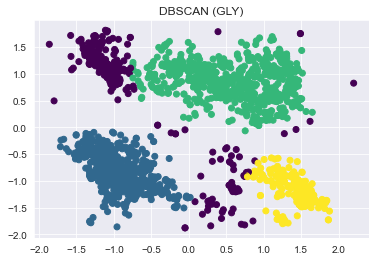

In [133]:
# generate DBSAN clustering
model_dbscan = DBSCAN(eps=0.5, min_samples=200).fit(X)
labels = model_dbscan.labels_
number_of_outliers = list(labels).count(-1) # outliers are given the label -1.
y_pred = model_dbscan.fit_predict(X)

df_GLY = df[(df['residue name'] == 'GLY')]
X = df_GLY[['phi shifted 360°', 'psi shifted 100°']]
X = StandardScaler().fit_transform(X)

# create 
plt.scatter(X[:,0], X[:,1],c=y_pred, cmap=CMAP)
plt.title("DBSCAN (GLY)")
plt.show()

GLYs data points unlike PRO is much more evenly spread out, forming 3 clusters. When we overlap this with the complete data, we can see that it follows it better. However, some trends can still be seen. Mainly in that GLY has a much higher rate of data points in the upper middle part and a much lower rate of data points in the middle right part of the plot compared to the original. This could be due to inherent randomness, however without deeper analysis it is hard to say.

Worth noting is that by looking at this plot there is another cluster in the upper left corner that is now treated as noise. This is probably because of our chosen eps and min_sample values and is another reason why DBSCAN have to be used carefully